# Azure AI Search: Scalar Quantization and Stored Property 

In addition to launching [new storage limits](https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/announcing-cost-effective-rag-at-scale-with-azure-ai-search/ba-p/4104961), Azure AI Search introduces two innovative features for optimizing price-performance: **Scalar Quantization** and a new **"stored" property** for vector fields.

## Features

### Scalar Quantization

Scalar Quantization is a compression technique for vector data. It reduces storage costs and enhances search performance without significantly compromising result accuracy. This method transforms high-dimensional vectors into a lower-bit representation, resulting in substantial storage savings.

### Stored Property

The "stored" property provides flexibility in managing storage costs by selectively storing document properties in the index. When set to False, the property isn't stored, which reduces the overall index size and cost, while maintaining searchability.

## Implementation

The implementation process involves several steps:

1. **Installation:** Install all necessary libraries to ensure the workspace has the latest versions of Azure Search Documents, OpenAI, and other dependencies.

2. **Index Creation:** Create or update indexes using the Azure Search Documents Index Client. The scenarios specified include:
   - `baseline`: The original index without optimizations.
   - `stored`: The Stored Property is set to False.
   - `scalar-quantization`: Applies Scalar Quantization compression.
   - `both`: Combines Scalar Quantization and Stored Property optimizations.

3. **Document Transformation and Uploading:** Transform the dataset into a list of dictionaries suitable for Azure AI Search ingestion. Upload these transformed documents in batches to the respective indexes created in the previous step.

## Install required libraries
This code block is used to install and upgrade the necessary Python libraries for the project:

- `azure-search-documents`: This is the Azure Search Documents library, which provides the necessary tools to interact with the Azure Search service.

- `openai`: This library is used to interact with the OpenAI API, which provides various AI models.

- `python-dotenv`: This library is used to read key-value pairs from a .env file and set them as environment variables.

- `azure-identity`: This library provides Azure Active Directory token authentication support across the Azure SDK.

- `datasets`: This library provides a collection of datasets with easy-to-use APIs for downloading and using them for model training and evaluation.

- `matplotlib`: This is a plotting library for Python and its numerical mathematics extension, NumPy. It provides an object-oriented API for embedding plots into applications.

- `prettytable`: This library is used to easily display tabular data in a visually appealing ASCII table format.

The `%pip install` command is a magic command in Jupyter notebooks, used to run pip commands directly from the notebook.

In [ ]:
%pip install --pre --upgrade azure-search-documents 
%pip install openai 
%pip install python-dotenv 
%pip install azure-identity
%pip install datasets
%pip install matplotlib
%pip install prettytable

## Initialize necessary imports

In [58]:
import json
import numpy as np
import os
import requests
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    AzureOpenAIVectorizer,
    AzureOpenAIParameters,
    HnswAlgorithmConfiguration,
    HnswParameters,
    ScalarQuantizationCompressionConfiguration,
    ScalarQuantizationParameters,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SearchableField,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
)
from azure.search.documents.models import VectorizedQuery, VectorizableTextQuery
from dotenv import load_dotenv

## Environment Setup and Client Initialization

This Python code block performs the following tasks:

1. **Environment Variables:** Loads environment variables from a `.env` file using `load_dotenv()`.

2. **OpenAI Client Setup:** Sets up the OpenAI client using environment variables for the endpoint, API key, and the name of the deployed model.

3. **Search Service Client Setup:** Sets up the Search Service client using environment variables for the endpoint and API key.

4. **Constants:** Defines constants such as the OpenAI API version and the index name.

5. **Authentication:** Chooses the appropriate credential based on the authentication method (Azure Active Directory or API key).

6. **Client Initialization:** Initializes the `SearchIndexClient` for creating indexes and the `SearchClient` for searching the index.

In [63]:
# Load environment variables from .env file
load_dotenv()

# Set up OpenAI client based on environment variables
AZURE_OPENAI_ENDPOINT: str = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY: str = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME: str = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_API_VERSION: str = "2023-05-15"

# Set up Search Service client based on environment variables
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")

# Other constants

INDEX_NAME = "dbpedia-1m"

# Authentication method flag
use_aad_for_search = False  # Set based on your authentication method

# Choose the correct credential based on your authentication method
credential = (
    DefaultAzureCredential()
    if use_aad_for_search
    else AzureKeyCredential(SEARCH_SERVICE_API_KEY)
)

# Initialize the SearchIndexClient for creating indexes
index_client = SearchIndexClient(
    endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential
)

# Initialize the SearchClient
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential, index_name=INDEX_NAME)

## Dataset Processing and Conversion

This Python code block loads a dataset, processes it by generating unique IDs and extracting relevant fields, and then converts it into a list of dictionaries for indexing. It uses multiprocessing and caching for efficient data processing.

In [ ]:
import uuid
from datasets import load_dataset

# Constants
DATASET_NAME = "KShivendu/dbpedia-entities-openai-1M"
BATCH_SIZE = 2000
NUM_PROC = 32

def process_batch(batch_data):
    """Processes a batch of data by generating unique IDs and extracting relevant fields."""
    return {
        "id": [str(uuid.uuid4()) for _ in range(len(batch_data["title"]))],  # Generate unique IDs using uuid4
        "title": batch_data["title"],
        "text": batch_data["text"],
        "embedding": batch_data["openai"],  # Ensure this field name matches your dataset schema
    }

# Load the entire dataset
dataset = load_dataset(DATASET_NAME, split="train")

# Convert the dataset to a list of dictionaries for indexing
# Enable caching to avoid reprocessing if the script is run multiple times
documents_to_index = dataset.map(
    process_batch,
    batched=True,
    batch_size=BATCH_SIZE,  # Adjust batch size based on your system's memory capacity and dataset size
    num_proc=NUM_PROC,  # Adjust based on the number of available CPU cores
    load_from_cache_file=True,
    remove_columns=dataset.column_names,
)

## Index Creation and Update

This Python code block defines functions to create or update an Azure AI Search index with different scenarios. It sets up fields, vector search profiles, algorithms, compressions, and vectorizers based on the scenario, and then creates or updates the index accordingly.

In [65]:
DIMENSIONS = 1536
HNSW_PARAMETERS = {"m": 4, "metric": "cosine", "ef_construction": 400, "ef_search": 500}
DEFAULT_OVERSAMPLING = 10
QUANTIZED_DATA_TYPE = "int8"

def create_fields(scenario):
    return [
        SimpleField(name="id", type=SearchFieldDataType.String, key=True),
        SearchField(name="title", type=SearchFieldDataType.String, searchable=True),
        SearchField(name="text", type=SearchFieldDataType.String, searchable=True),
        SearchField(
            name="embedding",
            type="Collection(Edm.Single)",
            vector_search_dimensions=DIMENSIONS,
            vector_search_profile_name=f"profile-{scenario}",
            stored=(scenario == "baseline" or scenario == "scalar-quantization"),
        ),
    ]

def create_vector_search_profiles(scenario):
    return [
        VectorSearchProfile(
            name=f"profile-{scenario}",
            algorithm_configuration_name=f"hnsw-{scenario}",
            compression_configuration_name=(
                f"compression-{scenario}"
                if scenario not in ["baseline", "stored"]
                else None
            ),
            vectorizer="myOpenAI",
        )
    ]

def create_algorithms(scenario):
    return [
        HnswAlgorithmConfiguration(
            name=f"hnsw-{scenario}",
            kind=VectorSearchAlgorithmKind.HNSW,
            parameters=HnswParameters(**HNSW_PARAMETERS),
        )
    ]

def create_compressions(scenario):
    compressions = []
    if scenario not in ["baseline", "stored"]:
        compressions.append(
            ScalarQuantizationCompressionConfiguration(
                name=f"compression-{scenario}",
                rerank_with_original_vectors=True,
                default_oversampling=DEFAULT_OVERSAMPLING,
                parameters=ScalarQuantizationParameters(quantized_data_type=QUANTIZED_DATA_TYPE),
            )
        )
    return compressions

def create_vectorizers():
    return [
        AzureOpenAIVectorizer(
            name="myOpenAI",
            kind="azureOpenAI",
            azure_open_ai_parameters=AzureOpenAIParameters(
                resource_uri=AZURE_OPENAI_ENDPOINT,
                deployment_id=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
                api_key=AZURE_OPENAI_API_KEY,
            ),
        ),
    ]

def create_or_update_index(client, index_name, scenario):
    fields = create_fields(scenario)
    vector_search_profiles = create_vector_search_profiles(scenario)
    algorithms = create_algorithms(scenario)
    compressions = create_compressions(scenario)
    vectorizers = create_vectorizers()

    vector_search = VectorSearch(
        profiles=vector_search_profiles,
        algorithms=algorithms,
        compressions=compressions,
        vectorizers=vectorizers,
    )

    index = SearchIndex(
        name=f"{index_name}-{scenario}", fields=fields, vector_search=vector_search
    )
    client.create_or_update_index(index=index)
    print(f"Index for {scenario} created or updated successfully.")

scenarios = ["baseline", "stored", "scalar-quantization", "both"]
for scenario in scenarios:
    create_or_update_index(index_client, INDEX_NAME, scenario)

Index for baseline created or updated successfully.
Index for stored created or updated successfully.
Index for scalar-quantization created or updated successfully.
Index for both created or updated successfully.


## Dataset Transformation

This Python code block defines a function to transform a dataset into the format required by Azure AI Search. It then applies this function to all documents in the dataset and prints the first few transformed documents to verify correctness.

In [ ]:
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

# Function to transform your dataset into the format required by Azure Search
def transform_to_search_document(record):
    return {
        "id": record["id"],
        "title": record["title"],
        "text": record["text"],
        "embedding": record["embedding"]
    }
    
# Transform all documents in the dataset
transformed_documents = [transform_to_search_document(doc) for doc in documents_to_index]

# Print the first few transformed documents to check correctness
print(transformed_documents[:10])


## Document Upload to Multiple Indexes with Concurrency

This Python code block creates a search client and uploads documents to multiple Azure Search indexes using concurrency for efficiency. The process is repeated for each index with a different index name.

1. **Search Client Creation:** The `create_search_client` function creates a `SearchClient` for a given index name.

2. **Document Upload:** The `upload_documents_to_index` function uploads documents to the index. It defines an inner function `upload_batch` to upload a batch of documents and handle any errors.

3. **Concurrency:** The `ThreadPoolExecutor` is used to upload multiple batches of documents concurrently. This is done to speed up the upload process by making use of multiple threads. The number of worker threads is defined by `NUM_WORKERS`. The documents are divided into batches of size `BATCH_SIZE`, and each batch is submitted to the executor for concurrent upload.

4. **Execution for Multiple Indexes:** A search client is created for each index (e.g., "dbpedia-1m-baseline", "dbpedia-1m-stored", etc.), and the transformed documents are uploaded to each index in turn.

In [9]:
from concurrent.futures import ThreadPoolExecutor
import logging

BATCH_SIZE = 1000
NUM_WORKERS = 10

def create_search_client(index_name):
    return SearchClient(
        endpoint=SEARCH_SERVICE_ENDPOINT, index_name=index_name, credential=credential
    )

def upload_documents_to_index(client, documents):
    def upload_batch(batch):
        try:
            result = client.merge_or_upload_documents(documents=batch)
            if result.is_error:
                for error in result.errors:
                    logging.error(
                        f"Failed to upload document with ID: {error.key}, error: {error.error.message}"
                    )
            else:
                logging.info("Successfully uploaded batch")
        except Exception as e:
            logging.error(f"Failed to upload batch: {e}")

    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for i in range(0, len(documents), BATCH_SIZE):
            batch = documents[i : i + BATCH_SIZE]
            executor.submit(upload_batch, batch)

index_name = "dbpedia-1m-baseline"
client = create_search_client(index_name)
upload_documents_to_index(client, transformed_documents)

In [10]:
from concurrent.futures import ThreadPoolExecutor
import logging

BATCH_SIZE = 1000
NUM_WORKERS = 10

def create_search_client(index_name):
    return SearchClient(
        endpoint=SEARCH_SERVICE_ENDPOINT, index_name=index_name, credential=credential
    )

def upload_documents_to_index(client, documents):
    def upload_batch(batch):
        try:
            result = client.merge_or_upload_documents(documents=batch)
            if result.is_error:
                for error in result.errors:
                    logging.error(
                        f"Failed to upload document with ID: {error.key}, error: {error.error.message}"
                    )
            else:
                logging.info("Successfully uploaded batch")
        except Exception as e:
            logging.error(f"Failed to upload batch: {e}")

    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for i in range(0, len(documents), BATCH_SIZE):
            batch = documents[i : i + BATCH_SIZE]
            executor.submit(upload_batch, batch)

index_name = "dbpedia-1m-stored"
client = create_search_client(index_name)
upload_documents_to_index(client, transformed_documents)

In [11]:
from concurrent.futures import ThreadPoolExecutor
import logging

BATCH_SIZE = 1000
NUM_WORKERS = 10

def create_search_client(index_name):
    return SearchClient(
        endpoint=SEARCH_SERVICE_ENDPOINT, index_name=index_name, credential=credential
    )

def upload_documents_to_index(client, documents):
    def upload_batch(batch):
        try:
            result = client.merge_or_upload_documents(documents=batch)
            if result.is_error:
                for error in result.errors:
                    logging.error(
                        f"Failed to upload document with ID: {error.key}, error: {error.error.message}"
                    )
            else:
                logging.info("Successfully uploaded batch")
        except Exception as e:
            logging.error(f"Failed to upload batch: {e}")

    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for i in range(0, len(documents), BATCH_SIZE):
            batch = documents[i : i + BATCH_SIZE]
            executor.submit(upload_batch, batch)

index_name = "dbpedia-1m-sclar-quantization"
client = create_search_client(index_name)
upload_documents_to_index(client, transformed_documents)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import logging

BATCH_SIZE = 1000
NUM_WORKERS = 10

def create_search_client(index_name):
    return SearchClient(
        endpoint=SEARCH_SERVICE_ENDPOINT, index_name=index_name, credential=credential
    )

def upload_documents_to_index(client, documents):
    def upload_batch(batch):
        try:
            result = client.merge_or_upload_documents(documents=batch)
            if result.is_error:
                for error in result.errors:
                    logging.error(
                        f"Failed to upload document with ID: {error.key}, error: {error.error.message}"
                    )
            else:
                logging.info("Successfully uploaded batch")
        except Exception as e:
            logging.error(f"Failed to upload batch: {e}")

    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for i in range(0, len(documents), BATCH_SIZE):
            batch = documents[i : i + BATCH_SIZE]
            executor.submit(upload_batch, batch)

index_name = "dbpedia-1m-both"
client = create_search_client(index_name)
upload_documents_to_index(client, transformed_documents)

## Index Statistics Retrieval

This Python code block retrieves and prints the statistics for multiple Azure Search indexes by iterating over a list of index names.

In [48]:
index_names = [
    "dbpedia-1m-baseline",
    "dbpedia-1m-stored",
    "dbpedia-1m-scalar-quantization",
    "dbpedia-1m-both",
]

for index_name in index_names:
    index_stats = index_client.get_index_statistics(index_name)
    print(index_stats)

{'document_count': 1000000, 'storage_size': 26467583470, 'vector_index_size': 7660344436}
{'document_count': 1000000, 'storage_size': 13652028798, 'vector_index_size': 6198710500}
{'document_count': 1000000, 'storage_size': 21990033509, 'vector_index_size': 1590767500}
{'document_count': 1000000, 'storage_size': 9037218208, 'vector_index_size': 1590697580}


## Index Statistics Comparison

The bar chart below presents a comparison of the storage size and vector index size for four different index configurations in Azure AI Search. Key takeways include:

- `dbpedia-1m-baseline` represents the standard index size without optimizations.
- `dbpedia-1m-stored` shows a reduced storage size, indicating that not storing certain properties can lead to cost savings.
- `dbpedia-1m-scalar-quantization` demonstrates a significant reduction in the vector index size, thanks to scalar quantization compressing the vector data.
- `dbpedia-1m-both` combines the benefits of not storing certain data properties with scalar quantization, resulting in the most substantial storage savings.



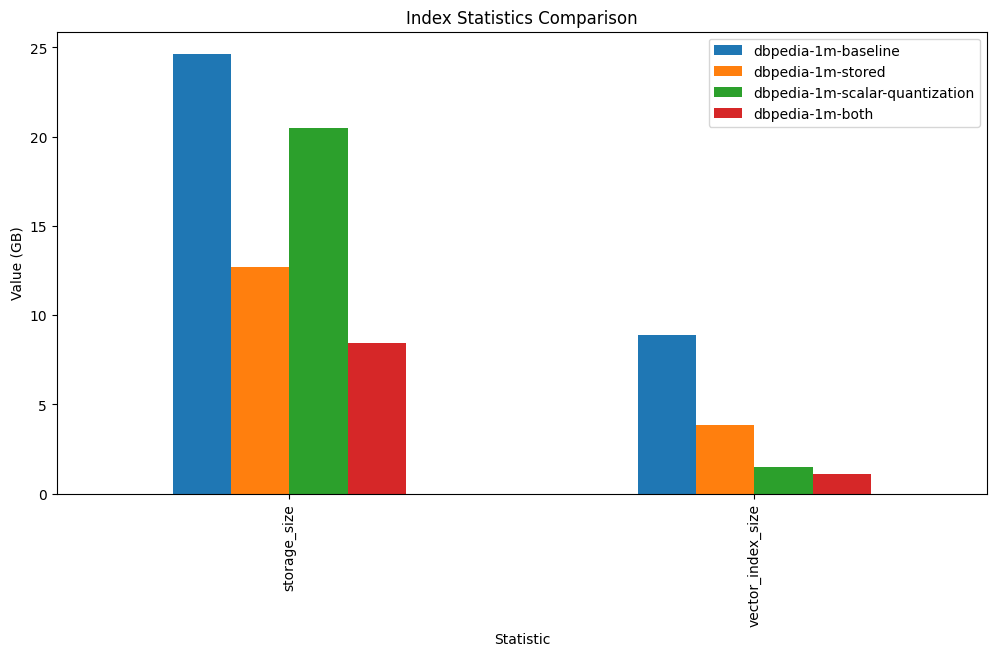

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

index_names = [
    "dbpedia-1m-baseline",
    "dbpedia-1m-stored",
    "dbpedia-1m-scalar-quantization",
    "dbpedia-1m-both",
]

# Create a DataFrame to store the statistics
df = pd.DataFrame()

for index_name in index_names:
    index_stats = index_client.get_index_statistics(index_name)
    # Assuming index_stats is a dictionary, convert it to a DataFrame and transpose it
    index_df = pd.DataFrame(index_stats, index=[0]).T
    # Add the DataFrame to our main DataFrame, setting the column name to the index name
    df[index_name] = index_df[0]

# Filter the DataFrame to only include the 'storageSize' and 'vectorIndexSize' statistics
df = df.loc[['storage_size', 'vector_index_size']]

# Convert Bytes to Gigabytes
df = df / (1024 ** 3)

# Plot the DataFrame
df.plot(kind='bar', figsize=(12, 6))
plt.title('Index Statistics Comparison')
plt.ylabel('Value (GB)')
plt.xlabel('Statistic')
plt.show()

## Total Size by Index and Statistic

The stacked bar chart below illustrates the total size of each index configuration, divided into `storage_size` and `vector_index_size`. Key takeaways include:

- `dbpedia-1m-baseline` shows the largest total size, indicating the original unoptimized index.
- `dbpedia-1m-stored` reduces the total index size due to optimizations in the storage properties.
- `dbpedia-1m-scalar-quantization` further decreases the total size with an emphasis on compressing the vector index, illustrating the impact of scalar quantization.
- `dbpedia-1m-both` achieves the lowest total size by combining storage property optimizations with scalar quantization, showcasing the most efficient use of storage.

This visualization underscores the effectiveness of Azure AI Search's optimization features in reducing the overall index size, leading to potential cost savings while supporting efficient search capabilities.


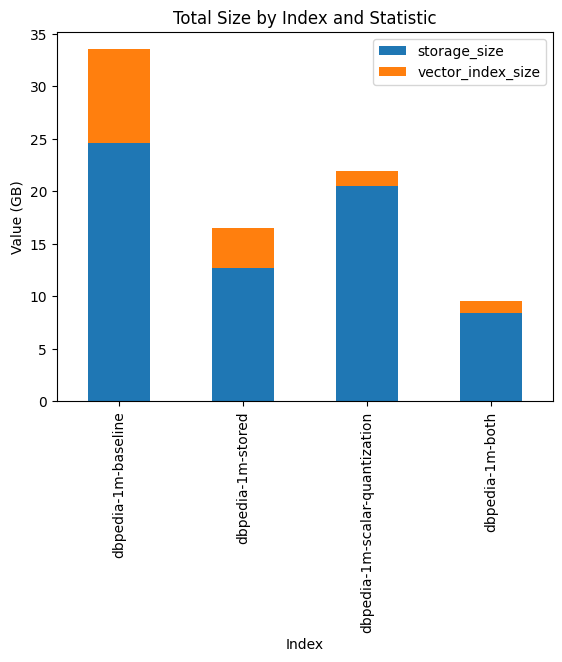

In [56]:
# Stacked bar chart
df.transpose().plot(kind='bar', stacked=True)
plt.title('Total Size by Index and Statistic')
plt.ylabel('Value (GB)')
plt.xlabel('Index')
plt.show()

## Total Size by Index and Statistic

The stacked bar chart below illustrates the total size of each index configuration, divided into `storage_size` and `vector_index_size`. Key takeaways include:

- `dbpedia-1m-baseline` shows the largest total size, indicating the original unoptimized index.
- `dbpedia-1m-stored` reduces the total index size due to optimizations in the storage properties.
- `dbpedia-1m-scalar-quantization` further decreases the total size with an emphasis on compressing the vector index, illustrating the impact of scalar quantization.
- `dbpedia-1m-both` achieves the lowest total size by combining storage property optimizations with scalar quantization, showcasing the most efficient use of storage.

This visualization underscores the effectiveness of Azure AI Search's optimization features in reducing the overall index size, leading to potential cost savings while supporting efficient search capabilities.


## Search Relevance and Score Consistency

The search results across different index configurations—`dbpedia-1m-baseline`, `dbpedia-1m-stored`, `dbpedia-1m-scalar-quantization`, and `dbpedia-1m-both`—showcase that the application of scalar quantization and stored property optimizations does not adversely affect search relevance. 

The scores across the indexes remain consistent, underscoring that even with significant storage savings, the precision and quality of search results are maintained. Note, that reranking and oversampling are recommended for mitigating the slight recall loss that comes with quantization. 


In [72]:
from prettytable import PrettyTable
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery
from azure.core.credentials import AzureKeyCredential

index_names = [
    "dbpedia-1m-baseline",
    "dbpedia-1m-stored",
    "dbpedia-1m-scalar-quantization",
    "dbpedia-1m-both",
]

query = "Who is considered one of the pioneers in computational linguistics?"

for index_name in index_names:
    # Create a new SearchClient for each index
    search_client = SearchClient(
        endpoint=SEARCH_SERVICE_ENDPOINT,
        index_name=index_name,
        credential=AzureKeyCredential(SEARCH_SERVICE_API_KEY),
    )
    vector_query = VectorizableTextQuery(
        text=query, k_nearest_neighbors=5, fields="embedding"
    )

    results = search_client.search(
        search_text=None,
        vector_queries=[vector_query],
        top=5,
    )

    # Create a PrettyTable instance
    table = PrettyTable()
    table.field_names = ["ID", "Title", "Text", "Score"]

    for result in results:
        table.add_row([result['id'], result['title'], result['text'], result['@search.score']])

    print(f"Results for index: {index_name}")
    print(table)
    print("\n")

Results for index: dbpedia-1m-baseline
+--------------------------------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|                  ID                  |      Title       |                                                                                                                                                                                                                                            Text                                                                                                                 